# The Relational Algebra in Python v2.


Copyright Jens Dittrich & Marcel Maltry, [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

### Imports

In [1]:
import operator  

from os import listdir

from graphviz import Source
from ra.relation import Relation
from ra.operators_log import *
from ra.operators_phys import *
from ra.utils import load_csv

### Application

In [2]:
# Data source: https://relational.fit.cvut.cz/dataset/IMDb
# Information courtesy of IMDb (http://www.imdb.com). Used with permission.
# Notice: The data can only be used for personal and non-commercial use and must not
# be altered/republished/resold/repurposed to create any kind of online/offline
# database of movie information (except for individual personal use).

path = 'data/IMDb_sample'  
# create a list of all files in that directory that end with "*.csv":
files = [file for file in listdir(path) if file.endswith('.csv')]

relations = [load_csv(path + '/' + file, file[:-4], delimiter='\t') for file in files]

relationsDict = {}
for rel in relations:
    relationsDict[rel.name] = rel
print(relationsDict)

{'movies_directors': <ra.relation.Relation object at 0x7f6914177bd0>, 'actors': <ra.relation.Relation object at 0x7f6914177d90>, 'directors': <ra.relation.Relation object at 0x7f691413cfd0>, 'movies_genres': <ra.relation.Relation object at 0x7f691413e2d0>, 'directors_genres': <ra.relation.Relation object at 0x7f691413fdd0>, 'movies': <ra.relation.Relation object at 0x7f69141418d0>, 'roles': <ra.relation.Relation object at 0x7f6914141fd0>}


In [3]:
# build LeafRelation object from relations dictionary
movies_directors = LeafRelation(relationsDict['movies_directors'])
actors = LeafRelation(relationsDict['actors'])
directors = LeafRelation(relationsDict['directors'])
movies_genres = LeafRelation(relationsDict['movies_genres'])
directors_genres = LeafRelation(relationsDict['directors_genres'])
movies = LeafRelation(relationsDict['movies'])
roles = LeafRelation(relationsDict['roles'])

In [4]:
directors.evaluate().print_set()

[directors] : {[id:int, first_name:str, last_name:str]}
{
	(11652, James (I), Cameron),
	(78273, Quentin, Tarantino),
	(43095, Stanley, Kubrick)
}


In [5]:
directors.evaluate().print_latex()

\definecolor{tableheadercolor}{rgb}{0.8,0.8,0.8}\begin{tabular}{|l|l|l|}\hline
\multicolumn{3}{|l|}{\cellcolor{tableheadercolor}{\textbf{directors}}}\\\hline
	\cellcolor{tableheadercolor}{\textbf{id}} & \cellcolor{tableheadercolor}{\textbf{first\textunderscore name}} & \cellcolor{tableheadercolor}{\textbf{last\textunderscore name}} \\
	\hline\hline
	11652 & James (I) & Cameron \\
	78273 & Quentin & Tarantino \\
	43095 & Stanley & Kubrick \\
\hline
\end{tabular}


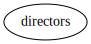

In [6]:
graph = directors.get_graph()
Source(graph)

# Selection

### Application

In [7]:
newmovies =  Selection_ScanBased(movies, 'year>2000')

In [8]:
print(newmovies)

σ_ScanBased[year>2000](movies)


In [9]:
newmovies.evaluate().print_set()

[Result] : {[id:int, name:str, year:int, rank:float]}
{
	(105938, Expedition: Bismarck, 2002, 7.5),
	(96779, Earthship.TV, 2001, 5.6),
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(10934, Aliens of the Deep, 2005, 6.5),
	(176712, Kill Bill: Vol. 2, 2004, 8.2),
	(159665, Inglorious Bastards, 2006, 8.3),
	(127297, Ghosts of the Abyss, 2003, 6.7)
}


In [10]:
newmovies.evaluate().name

'Result'

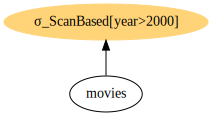

In [11]:
graph = newmovies.get_graph()
Source(graph)

# Projection


### Application

In [12]:
exp2 = Projection_ScanBased(newmovies, 'id, year')

In [13]:
print(exp2)

π_ScanBased[id, year](σ_ScanBased[year>2000](movies))


In [14]:
exp2.evaluate().print_set()

[Result] : {[id:int, year:int]}
{
	(96779, 2001),
	(393538, 2003),
	(176712, 2004),
	(176711, 2003),
	(127297, 2003),
	(159665, 2006),
	(105938, 2002),
	(10934, 2005)
}


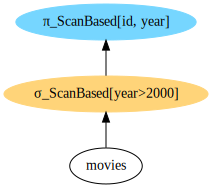

In [15]:
graph = exp2.get_graph()
Source(graph)

# Union

### Application

In [16]:
goodmovies = Selection_ScanBased(movies, 'rank>=7.5')
goodOrNew = Union_HashBased(goodmovies, newmovies)

In [17]:
print(goodOrNew)

(σ_ScanBased[rank>=7.5](movies)) ∪ (σ_ScanBased[year>2000](movies))


In [18]:
goodOrNew.evaluate().print_set()

[Result] : {[id:int, name:str, year:int, rank:float]}
{
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(387728, ER, 1994, 7.7),
	(177019, Killing, The, 1956, 8.1),
	(1711, 2001: A Space Odyssey, 1968, 8.3),
	(159665, Inglorious Bastards, 2006, 8.3),
	(65764, Clockwork Orange, A, 1971, 8.3),
	(30431, Barry Lyndon, 1975, 7.9),
	(96779, Earthship.TV, 2001, 5.6),
	(92616, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, 1964, 8.7),
	(164572, Jackie Brown, 1997, 7.5),
	(121538, Full Metal Jacket, 1987, 8.2),
	(105938, Expedition: Bismarck, 2002, 7.5),
	(193519, Lolita, 1962, 7.6),
	(267038, Pulp Fiction, 1994, 8.7),
	(328277, Terminator 2: Judgment Day, 1991, 8.1),
	(299073, Shining, The, 1980, 8.2),
	(250612, Paths of Glory, 1957, 8.6),
	(328285, Terminator, The, 1984, 7.9),
	(310455, Spartacus, 1960, 8.0),
	(10920, Aliens, 1986, 8.2),
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(10934, Aliens of the Deep, 2005, 6.5),
	(176712, Kill

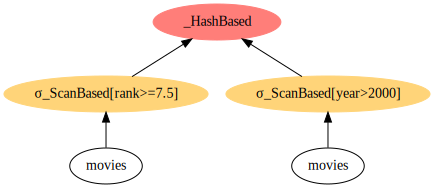

In [19]:
graph = goodOrNew.get_graph()
Source(graph)

Alternatively, without union but with two conditions in the selection instead.

In [20]:
goodOrNewSel = Selection_ScanBased(movies, 'year>2000 or rank>=7.5')

In [21]:
print(goodOrNewSel)

σ_ScanBased[year>2000 or rank>=7.5](movies)


In [22]:
goodOrNewSel.evaluate().print_set()

[Result] : {[id:int, name:str, year:int, rank:float]}
{
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(387728, ER, 1994, 7.7),
	(177019, Killing, The, 1956, 8.1),
	(159665, Inglorious Bastards, 2006, 8.3),
	(1711, 2001: A Space Odyssey, 1968, 8.3),
	(65764, Clockwork Orange, A, 1971, 8.3),
	(30431, Barry Lyndon, 1975, 7.9),
	(96779, Earthship.TV, 2001, 5.6),
	(92616, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, 1964, 8.7),
	(164572, Jackie Brown, 1997, 7.5),
	(121538, Full Metal Jacket, 1987, 8.2),
	(105938, Expedition: Bismarck, 2002, 7.5),
	(193519, Lolita, 1962, 7.6),
	(267038, Pulp Fiction, 1994, 8.7),
	(328277, Terminator 2: Judgment Day, 1991, 8.1),
	(299073, Shining, The, 1980, 8.2),
	(250612, Paths of Glory, 1957, 8.6),
	(328285, Terminator, The, 1984, 7.9),
	(310455, Spartacus, 1960, 8.0),
	(10920, Aliens, 1986, 8.2),
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(10934, Aliens of the Deep, 2005, 6.5),
	(176712, Kill

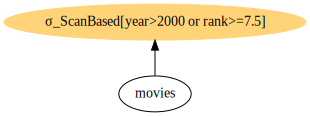

In [23]:
graph = goodOrNewSel.get_graph()
Source(graph)

# Difference


### Application

In [24]:
newButBadMovies = Difference_HashBased(newmovies, goodmovies)

In [25]:
print(newButBadMovies)

(σ_ScanBased[year>2000](movies)) − (σ_ScanBased[rank>=7.5](movies))


In [26]:
newButBadMovies.evaluate().print_set()

[Result] : {[id:int, name:str, year:int, rank:float]}
{
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(10934, Aliens of the Deep, 2005, 6.5),
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(96779, Earthship.TV, 2001, 5.6)
}


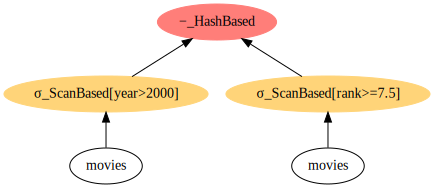

In [27]:
graph = newButBadMovies.get_graph()
Source(graph)

Alternatively, without intersection but with two conditions in the selection instead.

In [28]:
newButBadMoviesSel = Selection_ScanBased(movies, 'year>2000 and not rank>=7.5')

In [29]:
newButBadMoviesSel.evaluate().print_set()

[Result] : {[id:int, name:str, year:int, rank:float]}
{
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(10934, Aliens of the Deep, 2005, 6.5),
	(96779, Earthship.TV, 2001, 5.6)
}


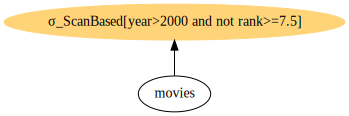

In [30]:
graph = newButBadMoviesSel.get_graph()
Source(graph)

# Renaming Relation

### Implementation

### Application

In [31]:
exp11 = Renaming_Relation_ScanBased(goodOrNew, 'good_or_new')

In [32]:
exp11.evaluate().print_set()

[good_or_new] : {[id:int, name:str, year:int, rank:float]}
{
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(387728, ER, 1994, 7.7),
	(177019, Killing, The, 1956, 8.1),
	(159665, Inglorious Bastards, 2006, 8.3),
	(1711, 2001: A Space Odyssey, 1968, 8.3),
	(65764, Clockwork Orange, A, 1971, 8.3),
	(30431, Barry Lyndon, 1975, 7.9),
	(96779, Earthship.TV, 2001, 5.6),
	(92616, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, 1964, 8.7),
	(164572, Jackie Brown, 1997, 7.5),
	(121538, Full Metal Jacket, 1987, 8.2),
	(105938, Expedition: Bismarck, 2002, 7.5),
	(193519, Lolita, 1962, 7.6),
	(267038, Pulp Fiction, 1994, 8.7),
	(328277, Terminator 2: Judgment Day, 1991, 8.1),
	(299073, Shining, The, 1980, 8.2),
	(250612, Paths of Glory, 1957, 8.6),
	(328285, Terminator, The, 1984, 7.9),
	(310455, Spartacus, 1960, 8.0),
	(10920, Aliens, 1986, 8.2),
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(10934, Aliens of the Deep, 2005, 6.5),
	(176712,

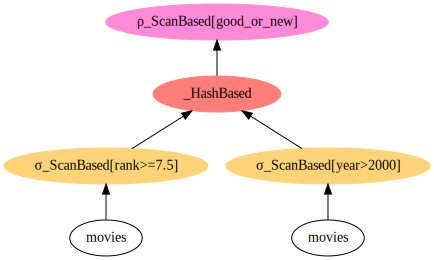

In [33]:
graph = exp11.get_graph()
Source(graph)

# Renaming Attributes

### Implementation

### Application

In [34]:
exp12 = Renaming_Attributes_ScanBased(exp11, 'movies<-name, published<-year')

In [35]:
exp12.evaluate().print_set(10)

[Result] : {[id:int, movies:str, published:int, rank:float]}
{
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(387728, ER, 1994, 7.7),
	(177019, Killing, The, 1956, 8.1),
	(1711, 2001: A Space Odyssey, 1968, 8.3),
	(159665, Inglorious Bastards, 2006, 8.3),
	(65764, Clockwork Orange, A, 1971, 8.3),
	(30431, Barry Lyndon, 1975, 7.9),
	(96779, Earthship.TV, 2001, 5.6),
	(92616, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, 1964, 8.7),
	(164572, Jackie Brown, 1997, 7.5)
}


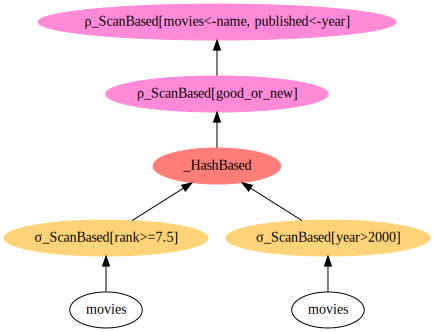

In [36]:
graph = exp12.get_graph()
Source(graph)

# Cartesian Product

### Application

In [37]:
cartesianProduct = Cartesian_Product_NestedLoop(directors, directors_genres)

In [38]:
print(cartesianProduct)

(directors) × (directors_genres)


In [39]:
directors.evaluate().print_set()

[directors] : {[id:int, first_name:str, last_name:str]}
{
	(11652, James (I), Cameron),
	(78273, Quentin, Tarantino),
	(43095, Stanley, Kubrick)
}


In [40]:
directors_genres.evaluate().print_set()

[directors_genres] : {[director_id:int, genre:str, prob:float]}
{
	(43095, Comedy, 0.125),
	(43095, Drama, 0.625),
	(43095, Documentary, 0.1875),
	(11652, Family, 0.0833333),
	(43095, Short, 0.1875),
	(11652, Adventure, 0.166667),
	(78273, Mystery, 0.125),
	(11652, Short, 0.25),
	(11652, Documentary, 0.25),
	(43095, War, 0.375),
	(78273, Crime, 0.5),
	(43095, Film-Noir, 0.125),
	(43095, Mystery, 0.0625),
	(11652, Sci-Fi, 0.5),
	(11652, Horror, 0.166667),
	(43095, Music, 0.0625),
	(78273, Thriller, 0.5),
	(78273, Drama, 0.75),
	(78273, Action, 0.5),
	(43095, Thriller, 0.1875),
	(11652, Drama, 0.25),
	(11652, Comedy, 0.0833333),
	(11652, Thriller, 0.416667),
	(78273, Romance, 0.125),
	(43095, Horror, 0.0625),
	(43095, Adventure, 0.0625),
	(43095, Crime, 0.1875),
	(43095, Action, 0.0625),
	(11652, Romance, 0.25),
	(78273, Comedy, 0.25),
	(11652, Fantasy, 0.0833333),
	(43095, Romance, 0.1875),
	(78273, War, 0.125),
	(43095, Sci-Fi, 0.1875),
	(11652, Action, 0.5)
}


In [41]:
len(directors_genres.evaluate()), len(directors.evaluate())

(35, 3)

In [42]:
print('number of expected tuples in cross product: ', len(directors_genres.evaluate())*len(directors.evaluate()))

number of expected tuples in cross product:  105


In [43]:
cartesianProduct.evaluate().print_set(10)

[Result] : {[id:int, first_name:str, last_name:str, director_id:int, genre:str, prob:float]}
{
	(78273, Quentin, Tarantino, 43095, War, 0.375),
	(43095, Stanley, Kubrick, 43095, Comedy, 0.125),
	(78273, Quentin, Tarantino, 43095, Music, 0.0625),
	(11652, James (I), Cameron, 11652, Drama, 0.25),
	(43095, Stanley, Kubrick, 43095, Thriller, 0.1875),
	(78273, Quentin, Tarantino, 43095, Crime, 0.1875),
	(78273, Quentin, Tarantino, 11652, Adventure, 0.166667),
	(78273, Quentin, Tarantino, 43095, Drama, 0.625),
	(43095, Stanley, Kubrick, 78273, Action, 0.5),
	(78273, Quentin, Tarantino, 78273, War, 0.125)
}


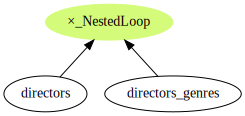

In [44]:
graph = cartesianProduct.get_graph()
Source(graph)

# Intersection

We use the generic `SetOperator` to compute the intersection of the sets of input tuples.

### Application

In [45]:
goodAndNew = Intersection_HashBased(newmovies, goodmovies)

In [46]:
goodAndNew.evaluate().print_set()

[Result] : {[id:int, name:str, year:int, rank:float]}
{
	(105938, Expedition: Bismarck, 2002, 7.5),
	(159665, Inglorious Bastards, 2006, 8.3),
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(176712, Kill Bill: Vol. 2, 2004, 8.2)
}


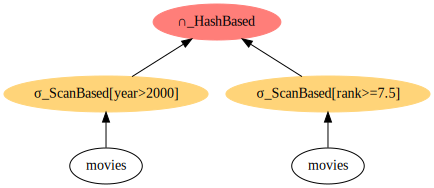

In [47]:
graph = goodAndNew.get_graph()
Source(graph)

Alternatively, without intersection but with two conditions in the selection instead:

In [48]:
goodAndNewSel = Selection_ScanBased(movies, "year>2000 and rank>=7.5")

In [49]:
goodAndNewSel.evaluate().print_latex()

\definecolor{tableheadercolor}{rgb}{0.8,0.8,0.8}\begin{tabular}{|l|l|l|l|}\hline
\multicolumn{4}{|l|}{\cellcolor{tableheadercolor}{\textbf{Result}}}\\\hline
	\cellcolor{tableheadercolor}{\textbf{id}} & \cellcolor{tableheadercolor}{\textbf{name}} & \cellcolor{tableheadercolor}{\textbf{year}} & \cellcolor{tableheadercolor}{\textbf{rank}} \\
	\hline\hline
	159665 & Inglorious Bastards & 2006 & 8.3 \\
	176711 & Kill Bill: Vol. 1 & 2003 & 8.4 \\
	105938 & Expedition: Bismarck & 2002 & 7.5 \\
	176712 & Kill Bill: Vol. 2 & 2004 & 8.2 \\
\hline
\end{tabular}


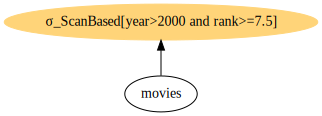

In [50]:
graph = goodAndNewSel.get_graph()
Source(graph)

# Theta Join

### Application

In [51]:
directorsAndTheirMovies = Theta_Join_NestedLoop(directors, movies_directors, "id==director_id")

In [52]:
directorsAndTheirMovies.evaluate().print_latex()

\definecolor{tableheadercolor}{rgb}{0.8,0.8,0.8}\begin{tabular}{|l|l|l|l|l|}\hline
\multicolumn{5}{|l|}{\cellcolor{tableheadercolor}{\textbf{Result}}}\\\hline
	\cellcolor{tableheadercolor}{\textbf{id}} & \cellcolor{tableheadercolor}{\textbf{first\textunderscore name}} & \cellcolor{tableheadercolor}{\textbf{last\textunderscore name}} & \cellcolor{tableheadercolor}{\textbf{director\textunderscore id}} & \cellcolor{tableheadercolor}{\textbf{movie\textunderscore id}} \\
	\hline\hline
	43095 & Stanley & Kubrick & 43095 & 121538 \\
	11652 & James (I) & Cameron & 11652 & 385710 \\
	11652 & James (I) & Cameron & 11652 & 322652 \\
	11652 & James (I) & Cameron & 11652 & 328277 \\
	43095 & Stanley & Kubrick & 43095 & 310455 \\
	11652 & James (I) & Cameron & 11652 & 256530 \\
	11652 & James (I) & Cameron & 11652 & 96779 \\
	43095 & Stanley & Kubrick & 43095 & 106666 \\
	78273 & Quentin & Tarantino & 78273 & 164572 \\
	78273 & Quentin & Tarantino & 78273 & 176711 \\
	43095 & Stanley & Kubrick & 430

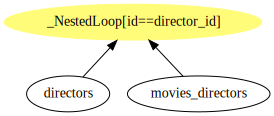

In [53]:
graph = directorsAndTheirMovies.get_graph()
Source(graph)

# Grouping

### Application

### Idea
Count the number of female/male actors.
* group by gender
* count the number of actors per group, count(*)

In [54]:
grouping = Grouping_HashBased(actors, 'gender', 'count(*)')

In [55]:
print(grouping)

(γ_[gender, count(*)] (actors)


In [56]:
grouping.evaluate().print_latex()

\definecolor{tableheadercolor}{rgb}{0.8,0.8,0.8}\begin{tabular}{|l|l|}\hline
\multicolumn{2}{|l|}{\cellcolor{tableheadercolor}{\textbf{Result}}}\\\hline
	\cellcolor{tableheadercolor}{\textbf{gender}} & \cellcolor{tableheadercolor}{\textbf{count\textunderscore star}} \\
	\hline\hline
	F & 289 \\
	M & 802 \\
\hline
\end{tabular}


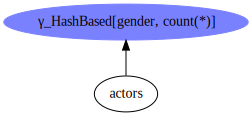

In [57]:
graph = grouping.get_graph()
Source(graph)

### Idea
* group by year
* count the number of movies per year, count(*)
* sum up the movie ids per year, sum(id)
* compute average movie id per year, avg(id)

The latter two do not make sense but show that multiple aggregations can be computed in one grouping.

In [58]:
grouping = Grouping_HashBased(movies, 'year', 'count(*), sum(id), avg(id)')

In [59]:
grouping.evaluate().print_set()

[Result] : {[year:int, count_star:int, sum_id:int, avg_id:float]}
{
	(1997, 2, 498428, 249214.0),
	(1968, 1, 1711, 1711.0),
	(1992, 1, 276217, 276217.0),
	(1953, 2, 402079, 201039.5),
	(1956, 1, 177019, 177019.0),
	(1978, 1, 369522, 369522.0),
	(1951, 2, 196085, 98042.5),
	(1957, 1, 250612, 250612.0),
	(1989, 1, 5306, 5306.0),
	(1995, 1, 118367, 118367.0),
	(1971, 1, 65764, 65764.0),
	(1994, 3, 995565, 331855.0),
	(1962, 1, 193519, 193519.0),
	(1991, 1, 328277, 328277.0),
	(1980, 1, 299073, 299073.0),
	(2002, 1, 105938, 105938.0),
	(2000, 1, 385710, 385710.0),
	(2006, 1, 159665, 159665.0),
	(1975, 1, 30431, 30431.0),
	(2005, 1, 10934, 10934.0),
	(1964, 1, 92616, 92616.0),
	(1981, 1, 256530, 256530.0),
	(1996, 1, 322652, 322652.0),
	(1955, 1, 176891, 176891.0),
	(2003, 3, 697546, 232515.33333333334),
	(1960, 1, 310455, 310455.0),
	(1999, 1, 106666, 106666.0),
	(1986, 1, 10920, 10920.0),
	(2004, 1, 176712, 176712.0),
	(2001, 1, 96779, 96779.0),
	(1987, 2, 345248, 172624.0),
	(1984, 1, 32

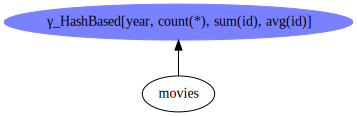

In [60]:
graph = grouping.get_graph()
Source(graph)

# Exercise: Equi-Join

In the following, you should implement the equi join operator in two steps:
1. Complete the implementation of the class `Equi_Join`. This class extends `BinaryOperator` and represents the logical operator equi join. In particular, the logical operator cannot be evaluated.
2. Complete the implementation of the class `Equi_Join_HashBased`. This class extends `Equi_Join` and adds evaluation functionality, i.e. it is a hash-based implemention of a physical operator.

Submit both the cell containing `class Equi_Join` and the cell containing `class Equi_Join_HashBased` in a text document.


## `Equi_Join`

Complete the following method:
* `get_schema()`: Returns the schema of the operator based on its childrens' schemas. You simply have to concatenate the schemas of the operator's children.

In [61]:
# Exercise
# Submit this code cell!
class Equi_Join(BinaryOperator):
    """The relational equi join

    Attributes:
        l_input (:obj: `Operator`): The left input to the equi join operator.
        r_input (:obj: `Operator`): The right input to the equi join operator.
        l_attrs (:obj: `string`): A comma-separated list of left attributes that should be equal.
        r_attrs (:obj: `string`): A comma-separated list of right attributes that should be equal.
    """
    def __init__(self, l_input, r_input, l_attrs, r_attrs):
        # call super constructor, stores child operators
        super().__init__(l_input, r_input)  
        # store list of join attributes in class variable
        self.l_attrs = str_to_list(l_attrs)  
        self.r_attrs = str_to_list(r_attrs)
        # set color and style node for dot graphs
        self.set_dot_attrs({'color':'#FFFC79', 'style': 'filled'})

    def __str__(self):
        """Returns a string representation of the operator tree rooted in this operator."""
        return f'({self.l_input}) ⋈_{{[{", ".join(self.l_attrs)}]}},{{[{", ".join(self.r_attrs)}]}} ({self.r_input})'

    def get_schema(self):
        """Returns the schema of the operator based on its childrens' schemas."""
        l_child_schema = self.l_input.get_schema()
        r_child_schema = self.r_input.get_schema()

        # integrity check (equally named attributes are not allowed here)
        l_attributes = [a for a, _ in l_child_schema]
        r_attributes = [a for a, _ in r_child_schema]
        assert len(set(l_attributes) & set(r_attributes)) == 0

        # Add your code here!
        # ...
        # Return the equi joins' schema. The equi joins' schema is defined as the
        # concatenation of the schema of the left child and the right child.
        pass  # Replace this line.

    def _dot(self, graph, prefix, caption='⋈_{{[{}]}},{{[{}]}}'):
        """Adds a node for the operator into the graph and returns the node's name."""
        # Define unique name within the graph
        node_name = prefix + 'Joi'
        # Fill caption's placeholders to obtain node label
        node_label = caption.format(', '.join(self.l_attrs), ', '.join(self.r_attrs))
        # Call `_dot_helper` to insert new node into graph
        self._dot_helper(graph, prefix, node_name, node_label)
        # Return node's name
        return node_name

### Application

Next, we call the methods that you just implemented. Consider the comments to see whether your implementation produces the expected results.

In [62]:
directors_and_movies = Equi_Join(directors, movies_directors, "id", "director_id")
print(directors_and_movies)

(directors) ⋈_{[id]},{[director_id]} (movies_directors)


In [63]:
schema = directors_and_movies.get_schema()
# This should print the operator's schema:
# [('id', <class 'int'>), ('first_name', <class 'str'>), ('last_name', <class 'str'>),
# ('director_id', <class 'int'>), ('movie_id', <class 'int'>)]
print(schema if schema is not None else "TODO: Implement get_schema().")

TODO: Implement get_schema().


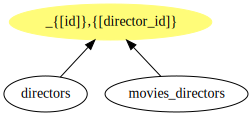

In [64]:
graph = directors_and_movies.get_graph()
Source(graph)

## `Equi_Join_HashBased`

Implement or complete the following methods:
* `_dot()`: Adds a node for the operator into the graph and returns the node's name. You can simply call the corresponding method of the super class' and replace the `caption` parameter.
* `evaluate()`: Returns a relation object containing the operators results. Make sure that your implementation is in O(n) where n is the number of result tuples of `l_input` and `r_input`.

In [65]:
# Exercise
# Submit this code cell!
class Equi_Join_HashBased(Equi_Join):
    def _dot(self, graph, prefix):
        """Adds a node for the operator into the graph and returns the node's name."""
        # Add your code here!
        # ...
        # Use the `_dot` method of the super class and simply overwrite the caption.
        # Inspect implementations of other operators in ra.operators_phys.
        pass

    def __str__(self):
        """Returns a string representation of the operator tree rooted in this operator."""
        return f'({self.l_input}) ⋈_HashBased{{[{", ".join(self.l_attrs)}]}},{{[{", ".join(self.r_attrs)}]}} ({self.r_input})'
    
    def evaluate(self):
        """Returns a relation object containing the operators results."""
        # Add your code here!
        # ...
        # Compute the operator's results. Do not use any other operators as subroutines!
        # Make sure that your implementation is in O(n) where n is the number of result
        # tuples of l_input and r_input.
        pass

### Application

Next, we call the methods that you just implemented. Consider the comments to see whether your implementation produces the expected results.

In [66]:
directors_and_movies = Equi_Join_HashBased(directors, movies_directors, "id", "director_id")
print(directors_and_movies)

(directors) ⋈_HashBased{[id]},{[director_id]} (movies_directors)


In [67]:
graph = directors_and_movies.get_graph()
# This should display the operator tree. The tree looks similar to the one above except that the label should
# also contain "HashBased".
Source(graph)

In [68]:
result = directors_and_movies.evaluate()
# This should print (part of) the result of the operator tree, order may vary depending on implementation:
# [(directors) ⋈_HashBased{[id]},{[director_id]} (movies_directors)] : {[id:int, first_name:str, last_name:str, director_id:int, movie_id:int]}
# {
#     (11652, James (I), Cameron, 11652, 256530),
#     (78273, Quentin, Tarantino, 78273, 276217),
#     (43095, Stanley, Kubrick, 43095, 116239)
#     WARNING: skipping 37 out of 40 tuples...
# }
if result is not None:
    result.print_set(3)
else:
    print("TODO: Implement evaluate().")

TODO: Implement evaluate().


## Testing

Finally, the unit test below helps you test whether your implementation of `evaluate()` works on some small examples. Note that this unit test only checks functional correctness. In particular, it does not check whether your implementation of `evaluate()` performs evaluation in O(n).

In [69]:
import unittest

class EquiJoinTest(unittest.TestCase):
    
    def test_evaluate(self):
        # set up two relations to join
        foo = Relation('foo', [('fid', int), ('name', str), ('bar_id', int)])
        foo.add_tuple( (1, 'first',  3) )
        foo.add_tuple( (2, 'second', 2) )
        foo.add_tuple( (3, 'third',  1) )
        foo.add_tuple( (4, 'fourth', 1) )
        rel_foo = LeafRelation(foo)
        
        bar = Relation('bar', [('bid', int), ('string', str), ('attr', int)])
        bar.add_tuple( (1, 'fourth',  42) )
        bar.add_tuple( (2, 'second',  99) )
        bar.add_tuple( (3, 'first',    0) )
        rel_bar = LeafRelation(bar)
        
        # join name=string
        with self.subTest(msg='name=string'):
            l_attrs='name'
            r_attrs='string'
            eq = Equi_Join_HashBased(rel_foo, rel_bar, l_attrs, r_attrs)
            res = eq.evaluate()
            
            self.assertEqual(len(res), 3)  # result contains 2tuples
            self.assertEqual(len(list(res.tuples)[0]), 6)  # result tuples have 6 attributes
            self.assertTrue((2, 'second', 2, 2, 'second', 99) in res.tuples)
            self.assertTrue((1, 'first',  3, 3, 'first',   0) in res.tuples)
            self.assertTrue((4, 'fourth', 1, 1, 'fourth', 42) in res.tuples)
            
        # join bar_id=bid
        with self.subTest(msg='bar_id=bid'):
            l_attrs='bar_id'
            r_attrs='bid'
            eq = Equi_Join_HashBased(rel_foo, rel_bar, l_attrs, r_attrs)
            res = eq.evaluate()
        
            self.assertEqual(len(res), 4)  # result contains 4 tuples
            self.assertEqual(len(list(res.tuples)[0]), 6)  # result tuples have 6 attributes
            self.assertTrue((1, 'first',  3, 3, 'first',   0) in res.tuples)
            self.assertTrue((2, 'second', 2, 2, 'second', 99) in res.tuples)
            self.assertTrue((3, 'third',  1, 1, 'fourth', 42) in res.tuples)
            self.assertTrue((4, 'fourth', 1, 1, 'fourth', 42) in res.tuples)
        
        # join bar_id=bid and name=string
        with self.subTest(msg='bar_id=bid and name=string'):
            l_attrs='bar_id, name'
            r_attrs='bid, string'
            eq = Equi_Join_HashBased(rel_foo, rel_bar, l_attrs, r_attrs)
            res = eq.evaluate()
            
            self.assertEqual(len(res), 3)  # result contains 2tuples
            self.assertEqual(len(list(res.tuples)[0]), 6)  # result tuples have 6 attributes
            self.assertTrue((1, 'first',  3, 3, 'first',   0) in res.tuples)
            self.assertTrue((2, 'second', 2, 2, 'second', 99) in res.tuples)
            self.assertTrue((4, 'fourth', 1, 1, 'fourth', 42) in res.tuples)

In [70]:
# Run the unit test without shutting down the jupyter kernel
unittest.main(argv=['ignored', '-v'], verbosity=2, exit=False)

test_evaluate (__main__.EquiJoinTest) ... 
ERROR: test_evaluate (__main__.EquiJoinTest) [name=string]
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-69-5f8cb6f2cf49>", line 27, in test_evaluate
    self.assertEqual(len(res), 3)  # result contains 2tuples
TypeError: object of type 'NoneType' has no len()

ERROR: test_evaluate (__main__.EquiJoinTest) [bar_id=bid]
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-69-5f8cb6f2cf49>", line 40, in test_evaluate
    self.assertEqual(len(res), 4)  # result contains 4 tuples
TypeError: object of type 'NoneType' has no len()

ERROR: test_evaluate (__main__.EquiJoinTest) [bar_id=bid and name=string]
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-69-5f8cb6f2cf49>", line 54, in test_evaluate
    self.assertEqua